# Test Notebook for FungAI

Don't forget to to execute the `pip install -r requirements.txt` command in the terminal to update all the packages of the envirement

## Pyhton Imports

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True # important to avoir an error (the truncated picture error)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer


## Loading images + Processing

Let's first load one image and print it (as well as its shape)

In [2]:
image = plt.imread('raw_data/Mushrooms/Agaricus/000_ePQknW8cTp8.jpg')

(600, 778, 3)


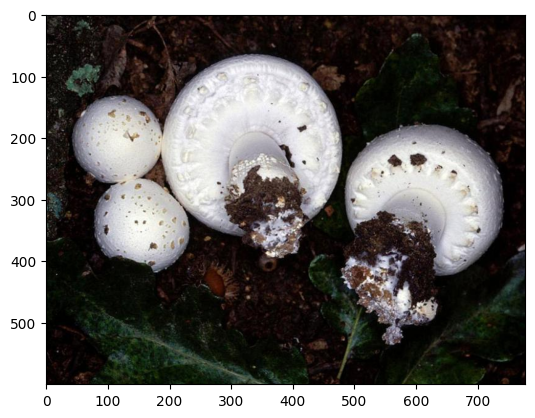

In [3]:
plt.imshow(image)
print(image.shape)

In [4]:
image.shape

(600, 778, 3)

Everything works fine so now let's load all the images and their classes :

In [22]:
_X = []
_y = []

idx = 0
for genus in os.listdir("raw_data/Mushrooms"):
    for image in os.listdir(f"raw_data/Mushrooms/{genus}"):
        temp_img = plt.imread( os.path.join("raw_data/Mushrooms", genus, image))
        if len(temp_img.shape) < 3 : # necessary because there is an image that has no RGB dimension (wtf ??)
                continue
        trans_img = cv2.resize(temp_img, (100, 100), interpolation = cv2.INTER_AREA) # normlizing the pixels of images
        _X.append(trans_img)
        _y.append(genus)
        idx += 1
    print(idx/6700*100)

X = np.concatenate(_X , axis = 0).reshape((idx, 100,100,3)) # putting an image as one item in the tensor
y = np.array(_y)

In [23]:
np.unique(y)

array(['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma',
       'Hygrocybe', 'Lactarius', 'Russula', 'Suillus'], dtype='<U11')

*Here the image compression is not done, it's just a resizing, the images are stretch*

Print a random image to check that everything seems fine

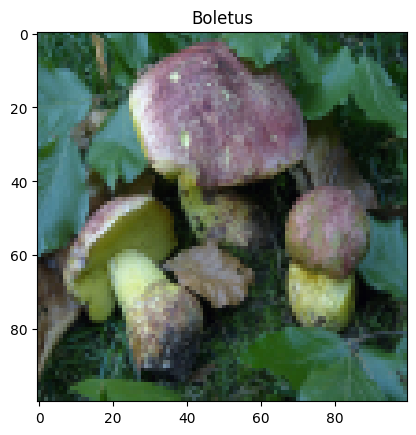

In [6]:
from random import randint
index = randint(0, len(X))

plt.imshow(X[index])
plt.title(y[index]);

Now we can save the preprocessed images in a folder :

If you got an error it's probably because you need to create the directory (`mkdir processed` in terminal) 

**Don't forget to add it to the `.gitignore` file otherwise it will be super long to push...**

In [7]:
# save processed images in a file can be loaded with np.load(file.npy)
np.save("processed/X.npy", X)
np.save("processed/y.npy", y)

By doing this when we reuse this notebook, instead of rerunning the whole images loading, we can directly load the preprocessed ones :

*still take some time though*

## data prep + basic model

In [8]:
X = np.load("processed/X.npy")
y = np.load("processed/y.npy")

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

Encode the y dataset to categorical variables

In [10]:
y_train = np.array(y_train)
y_train_unique = np.unique(y_train)
y_train_unique

array(['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma',
       'Hygrocybe', 'Lactarius', 'Russula', 'Suillus'], dtype='<U11')

In [11]:
labels = ['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma',
         'Hygrocybe', 'Lactarius', 'Russula', 'Suillus' ]

In [12]:
from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()
encoder.fit(labels)
y_train_cat = encoder.transform(y_train)
print(y_train_cat)
y_test_cat = encoder.transform(y_test)

[[0 0 0 ... 0 1 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 1 0]]


In [13]:
assert(y_train_cat.shape == (4497,9))
assert(y_test_cat.shape == (2215,9))

In [14]:
X_train = X_train/255
X_test = X_test/255
X_train.shape


(4497, 100, 100, 3)

## Starting a base CNN model

In [15]:
from tensorflow import keras
from keras import models, layers

2022-11-29 12:56:20.909838: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-29 12:56:21.107738: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ada/.pyenv/versions/3.10.6/envs/fungai/lib/python3.10/site-packages/cv2/../../lib64:
2022-11-29 12:56:21.107765: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-29 12:56:22.149562: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library

In [16]:
def initialize_model():

    model = models.Sequential()

    ### First Convolution & MaxPooling
    model.add(layers.Conv2D(8,(4,4), activation='relu',padding='same',input_shape=(100,100,3)))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    ### Second Convolution & MaxPooling
    model.add(layers.Conv2D(16, (3,3), activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    model.add(layers.Flatten())
    
    
    ### Last layer - Classification Layer with 9 outputs corresponding to 9 mushrooms labels
    model.add(layers.Dense(9,activation='softmax'))
    
    ### Model compilation
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model
    

In [17]:
model = initialize_model()
model.summary()

2022-11-29 12:56:23.764742: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ada/.pyenv/versions/3.10.6/envs/fungai/lib/python3.10/site-packages/cv2/../../lib64:
2022-11-29 12:56:23.770047: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-29 12:56:23.770170: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (debian): /proc/driver/nvidia/version does not exist
2022-11-29 12:56:23.807138: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 8)       392       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 9)                 8

In [18]:
from tensorflow.keras.callbacks import EarlyStopping
model = initialize_model()
es = EarlyStopping()
model.fit(X_train,y_train_cat, batch_size=16, epochs=5, callbacks=[es], verbose=1, validation_split=0.2)

Epoch 1/5
225/225 [==============================] - 18s 72ms/step - loss: 1.9838 - accuracy: 0.2669 - val_loss: 1.8052 - val_accuracy: 0.3522
Epoch 2/5
225/225 [==============================] - 16s 70ms/step - loss: 1.7179 - accuracy: 0.3853 - val_loss: 1.7471 - val_accuracy: 0.3778


TypeError: cannot unpack non-iterable History object

In [ ]:
history

In [2]:
img = plt.imread("FungAI/Agaricus_campestre.jpeg")

In [4]:
img.shape

(568, 800, 3)

In [9]:
import pandas as pd

In [19]:
trans_img = cv2.resize(img, (100, 100), interpolation = cv2.INTER_AREA)
X = np.concatenate(trans_img , axis = 0).reshape((1,100,100,3))

In [20]:
X.shape

(1, 100, 100, 3)